<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_VectorQuantized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Neural Discrete Representation Learning: https://arxiv.org/abs/1711.00937  
Generating Diverse High-Fidelity Images with VQ-VAE-2: https://arxiv.org/abs/1906.00446

VQ-VAE example: https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [0]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

# Create some data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=5, n_features=32,random_state=3)
data_variance = np.var(X)

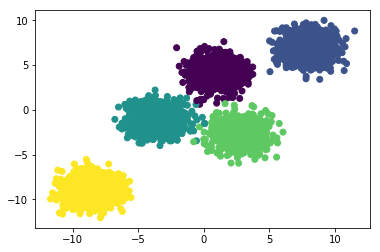

In [34]:
plt.scatter(X[:,0], X[:,1], c=y);

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(16)(x)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(8)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(4)(h)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = snt.Linear(8)(x)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(16)(h)
    h = tf.nn.leaky_relu(h)
    h = snt.Linear(self.output_dim)(h)
    return h

# Build Graph and train

In [49]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32

num_training_updates = 5000
embedding_dim = 4
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 20

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
z = encoder(x)

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_samples(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 1000 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-200:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-200:]))
    print()


1000 iterations
recon_error: 0.278
perplexity: 5.253

2000 iterations
recon_error: 0.039
perplexity: 4.716

3000 iterations
recon_error: 0.031
perplexity: 4.710

4000 iterations
recon_error: 0.031
perplexity: 4.674

5000 iterations
recon_error: 0.031
perplexity: 4.699



# Plot loss

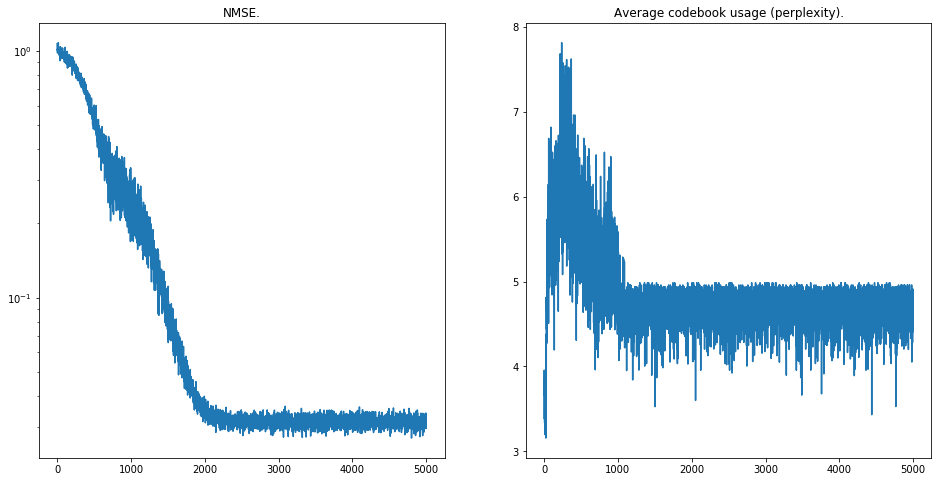

In [50]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).');

# View latent space

In [0]:
# Latent space
z_, vq_output_eval_, x_recon_  = sess.run([z, vq_output_eval, x_recon], feed_dict={x: X})

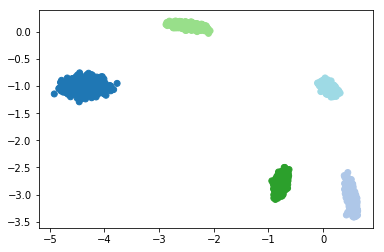

In [59]:
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'], cmap='tab20');

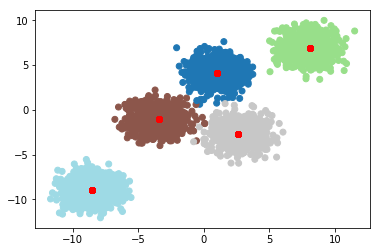

In [61]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='tab20');
plt.scatter(x_recon_[:,0], x_recon_[:,1], c='red');

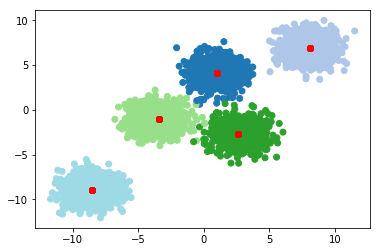

In [62]:
plt.scatter(X[:,0], X[:,1], c=vq_output_eval_['encoding_indices'], cmap='tab20');
plt.scatter(x_recon_[:,0], x_recon_[:,1], c='red');